## GANs

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transformers
import torchvision.datasets as datasets
import torchvision.utils as utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
batch_size = 128
image_size = 28*28
transformer = transformers.Compose([
    transformers.ToTensor(),
    transformers.Normalize((0.5,), (0.5,))
])

In [6]:
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transformer)

100%|██████████| 9.91M/9.91M [00:16<00:00, 618kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 209kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 646kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 17.5MB/s]


In [7]:
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features=image_size, out_features=1024),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(in_features=1024, out_features=512),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(in_features=512, out_features=256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.view(-1, image_size))

In [16]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features=z_dim, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=image_size),
            nn.Tanh()

        )

    def forward(self, x):
        return self.model(x).view(-1, 1, 28, 28)

In [23]:
learning_rate = 0.0002
z_dim = 100
epochs = 20

In [24]:
generator = Generator(z_dim=z_dim).to(device=device)
discriminator = Discriminator().to(device=device)

In [25]:
loss_fn = nn.BCELoss()
optimizer_generator = optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [26]:
for epoch in range(epochs):
    for i, (real_img, _) in enumerate(dataloader):
        real_img = real_img.to(device=device)
        batch_size = real_img.size(0)
        real_labels = torch.ones(batch_size, 1).to(device=device)
        fake_labels = torch.zeros(batch_size, 1).to(device=device)

        # discriminator train
        z = torch.randn(batch_size, z_dim).to(device=device)
        fake_img = generator(z)
        real_loss = loss_fn(discriminator(real_img), real_labels)
        fake_loss = loss_fn(discriminator(fake_img.detach()), fake_labels)
        discriminator_loss = real_loss + fake_loss

        optimizer_discriminator.zero_grad()
        discriminator_loss.backward()
        optimizer_discriminator.step()

        # generator train
        generator_loss = loss_fn(discriminator(fake_img), real_labels)
        optimizer_generator.zero_grad()
        generator_loss.backward()
        optimizer_generator.step()

    print(f"Epoch: {epoch+1}/{epochs}, Generator Loss: {generator_loss:.3f}, Discriminator Loss: {discriminator_loss:.3f}")

Epoch: 1/20, Generator Loss: 3.949, Discriminator Loss: 0.444
Epoch: 2/20, Generator Loss: 8.668, Discriminator Loss: 0.491
Epoch: 3/20, Generator Loss: 2.932, Discriminator Loss: 0.155
Epoch: 4/20, Generator Loss: 2.123, Discriminator Loss: 0.457
Epoch: 5/20, Generator Loss: 2.649, Discriminator Loss: 0.259
Epoch: 6/20, Generator Loss: 5.865, Discriminator Loss: 0.415
Epoch: 7/20, Generator Loss: 3.144, Discriminator Loss: 0.349
Epoch: 8/20, Generator Loss: 2.945, Discriminator Loss: 0.432
Epoch: 9/20, Generator Loss: 1.614, Discriminator Loss: 0.606
Epoch: 10/20, Generator Loss: 2.350, Discriminator Loss: 0.632
Epoch: 11/20, Generator Loss: 1.817, Discriminator Loss: 0.561
Epoch: 12/20, Generator Loss: 1.400, Discriminator Loss: 1.021
Epoch: 13/20, Generator Loss: 1.807, Discriminator Loss: 0.633
Epoch: 14/20, Generator Loss: 2.249, Discriminator Loss: 0.688
Epoch: 15/20, Generator Loss: 1.309, Discriminator Loss: 0.718
Epoch: 16/20, Generator Loss: 2.685, Discriminator Loss: 0.857
E

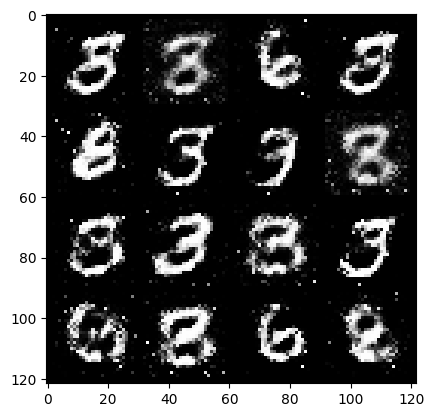

In [28]:
with torch.no_grad():
    z = torch.rand(16, z_dim).to(device=device)
    samples_images = generator(z).cpu()
    grid = np.transpose(utils.make_grid(samples_images, nrow=4, normalize=True), (1, 2, 0))

    plt.imshow(grid)
    plt.show()